<a href="https://colab.research.google.com/github/arnu123/TurboMLExploration/blob/main/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TurboML Exploration

In [1]:
!pip install -q turboml-installer
import turboml_installer ; turboml_installer.install_on_colab()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.6/821.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.1 MB/s eta 0:00:00
📦 Installing...
🩹 Patching environment...
⏲ Done in 0:00:55
🔁 Restarting kernel...


In [1]:
import turboml as tb

tb.init(
  backend_url="https://infrared-barracuda.api.turboml.online",
  api_key="tb_dg2X49N3v7tW8Vox5rdFvP9suqYegQZA_5305bc58"
)

In [2]:
!pip install onnx==1.14.1 scikit-learn skl2onnx

  Using cached protobuf-3.20.2-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.2-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
protobuf-to-pydantic 0.3.0.3 requires protobuf>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
turboml-sdk 0.1.5 requires protobuf<6.0.0,>=5.28.3, but you have protobuf 3.20.2 which is incompatible.


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.helpers.onnx_helper import select_model_inputs_outputs
import matplotlib.pyplot as plt

### Dealing with the data

In [5]:
bank_df = pd.read_csv("bank.csv")

In [6]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [7]:
bank_df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [8]:
# Lets explore the unique values in each column of bank_df
for col in bank_df.columns:
    print(col, bank_df[col].unique())

age [59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89]
job ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital ['married' 'single' 'divorced']
education ['secondary' 'tertiary' 'primary' 'unknown']
default ['no' 'yes']
balance [2343   45 1270 ... 1594 2593 -134]
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
duration [1042 1467 1389 ... 1504  818 1812]
campaign [ 1  2  3  4  6  5  8 11  9 10 15 12 14  7 24 13 17 29 21 20 16 32 19 25
 22 43 18 41 63 27 30 26 23 28 33 31]
pdays [ -1 166  91 147

#### There is no pre-defined primary key. Hence, we use the inbuilt index as the primary key.

In [9]:
bank_df['primary_key'] = bank_df.index

In [10]:
#lets see what unique values are there in pdays column
bank_df['pdays'].unique()

array([ -1, 166,  91, 147, 170, 150, 171, 126, 182, 110, 198, 174, 175,
        27, 128, 100, 177, 167, 122, 183, 195, 133, 178,  34,  10, 163,
       184, 154,  99,  93,   2, 242, 272,  76, 160,  90, 196, 246, 238,
       203, 268, 189, 267,  92,   9,  88,  85, 210, 257, 261, 270, 106,
       199, 112,  41, 294, 231, 239, 302, 135, 307, 222, 138, 323, 141,
       320, 264, 316, 315, 256, 146, 328,  74, 148, 327, 341, 145, 266,
       234, 345, 318, 325, 274, 343, 260, 305, 344, 254, 180, 340,  82,
       181, 278, 153,   4, 349, 334, 176,  87, 269,  86, 169,  83,  79,
         6, 259,  13, 161, 350,  84,  80, 164,  22, 296,  66, 263, 333,
        17,  89,  78, 286, 337, 364, 188, 342, 363, 352, 295, 353, 356,
       288, 367, 366, 359, 347, 370, 284, 300, 306, 361, 287, 301, 355,
       371, 292, 360, 358, 346, 357, 368, 312, 179, 329, 298, 372, 374,
       375, 291,  95, 109,  94,  98, 186, 101, 187, 321,  40,  96,  21,
        35,  97, 285, 103, 212, 293,  81,  38,  28,  67,  60, 12

##### There are '-1' values in pdays representing clients who have never been contacted. Thus, we ignore these.


In [11]:
bank_df = bank_df[bank_df['pdays']!=-1]

In [12]:
labels_df = bank_df[['primary_key','deposit']]
bank_df = bank_df.drop('deposit', axis=1)

In [13]:
# Lets convert the values in column "deposit" to binary.
labels_df['deposit'] = labels_df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [14]:
joined_df = pd.merge(bank_df, labels_df, on="primary_key", how="right")
joined_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,primary_key,deposit
0,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,890,1
1,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,891,1
2,56,technician,married,secondary,no,589,yes,no,unknown,23,oct,518,1,147,2,success,899,1
3,34,admin.,married,tertiary,no,899,yes,no,unknown,12,nov,114,1,170,3,failure,933,1
4,53,retired,married,tertiary,no,2269,no,no,cellular,17,nov,1091,2,150,1,success,951,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,40,blue-collar,divorced,primary,no,54,yes,no,cellular,13,may,10,5,362,3,other,11125,0
2834,37,management,married,tertiary,no,1594,yes,no,cellular,17,apr,110,1,260,5,failure,11133,0
2835,60,retired,divorced,tertiary,no,-134,no,no,cellular,12,may,243,1,271,4,failure,11145,0
2836,35,blue-collar,married,secondary,no,80,yes,yes,cellular,21,nov,38,2,172,2,failure,11155,0


In [15]:
X = joined_df.drop("deposit", axis=1)
y = joined_df["deposit"]

In [16]:
X_encoded = pd.get_dummies(X) #one-hot for categorical variables encoding

In [17]:
# lets change job_admin. to job_admin column name
X_encoded.rename(columns={'job_admin.': 'job_admin'}, inplace=True)
X_encoded.rename(columns={'job_blue-collar': 'job_blue_collar'}, inplace=True)
X_encoded.rename(columns={'job_self-employed': 'job_self_employed'}, inplace=True)

In [18]:
# lets change job_admin. to job_admin column name
bank_df.rename(columns={'job_admin.': 'job_admin'}, inplace=True)
bank_df.rename(columns={'job_blue-collar': 'job_bluecollar'}, inplace=True)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9985915492957746


In [27]:
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
onx = convert_sklearn(
    clf, initial_types=initial_type, options={type(clf): {"zipmap": False}}
)
onx = select_model_inputs_outputs(onx, outputs=["probabilities"])

# TurboML Data Digestion and Model Building

In [28]:
bank = tb.OnlineDataset.from_pd(
    id="details7",
    df=bank_df,
    key_field="primary_key",
    load_if_exists=True,
)

labels = tb.OnlineDataset.from_pd(
    id="details_labels5",
    df=labels_df,
    key_field="primary_key",
    load_if_exists=True,
)

INFO:turboml.common.dataloader:Uploading 2838 rows to dataset details7
Progress: 100%|██████████| 2.84k/2.84k [00:00<00:00, 3.24krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
INFO:turboml.common.dataloader:Uploading 2838 rows to dataset details_labels5
Progress: 100%|██████████| 2.84k/2.84k [00:00<00:00, 516krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.


In [29]:
bank.feature_engineering.get_local_features()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,primary_key
0,45,entrepreneur,married,secondary,no,781,no,yes,cellular,17,nov,652,2,126,2,failure,953
1,34,management,single,tertiary,no,1494,yes,no,cellular,18,nov,596,1,182,1,other,961
2,46,management,married,tertiary,no,0,no,no,cellular,18,nov,716,2,110,3,other,968
3,43,management,married,tertiary,no,1429,yes,no,cellular,19,nov,1015,1,198,2,other,977
4,33,technician,single,tertiary,no,149,yes,no,cellular,19,nov,424,2,182,1,other,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,38,services,married,tertiary,no,0,yes,no,cellular,17,apr,239,1,147,4,failure,11092
2834,46,management,married,secondary,no,21,yes,no,cellular,7,may,124,1,338,2,failure,11098
2835,37,management,married,tertiary,no,1594,yes,no,cellular,17,apr,110,1,260,5,failure,11133
2836,35,blue-collar,married,secondary,no,80,yes,yes,cellular,21,nov,38,2,172,2,failure,11155


In [31]:
numerical_fields = ['age','balance','day','duration','campaign','pdays','previous']

features = bank.get_model_inputs(numerical_fields=numerical_fields)
label = labels.get_model_labels(label_field="deposit")

In [32]:
tb.set_onnx_model("randomforest", onx.SerializeToString())
onnx_model = tb.ONNX(model_save_name="randomforest")

In [34]:
deployed_model = onnx_model.deploy("onnx_model1", input=features, labels=label)

In [35]:
deployed_model.add_metric("WindowedAUC")

### Checking TurboML inbuilt algorithms

In [67]:
tb.ml_algorithms(have_labels=False)

['MStream', 'RCF', 'HST', 'ONNX']

Let's use the RandomCutForest (RCF) algorithm.

In [38]:
model = tb.RCF(number_of_trees=50)

In [40]:
deployed_model_rcf = model.deploy(name="explore_unsup1", input=features, labels=label)

In [41]:
outputs = deployed_model_rcf.get_outputs()

INFO:turboml.common.dataloader:Yielded 2838 records (1 batches) in 2 seconds
INFO:turboml.common.dataloader:Yielded 2838 records (1 batches) in 2 seconds


In [42]:
sample_output = outputs[-1]
sample_output

{'offset': 2837,
 'record': key: "11160"
 score: 0.732617199
 feature_score: 0.0398406424
 feature_score: 0.398406386
 feature_score: 0.023904385
 feature_score: 0.00796812773
 feature_score: 0.023904385
 feature_score: 0.498007983
 feature_score: 0.00796812773}

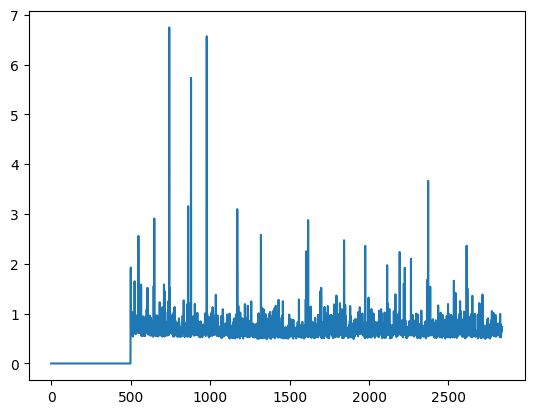

In [43]:
import matplotlib.pyplot as plt

plt.plot([output["record"].score for output in outputs])

In [46]:
model_endpoints = deployed_model_rcf.get_endpoints()
model_endpoints

['https://infrared-barracuda.api.turboml.online/model/_turboml.explore_unsup1/predict']

In [44]:
model_query_datapoint = bank_df.iloc[-1].to_dict()
model_query_datapoint

{'age': 43,
 'job': 'technician',
 'marital': 'married',
 'education': 'secondary',
 'default': 'no',
 'balance': 0,
 'housing': 'no',
 'loan': 'yes',
 'contact': 'cellular',
 'day': 8,
 'month': 'may',
 'duration': 9,
 'campaign': 2,
 'pdays': 172,
 'previous': 5,
 'poutcome': 'failure',
 'primary_key': 11160}

In [47]:
import requests

resp = requests.post(
    model_endpoints[0], json=model_query_datapoint, headers=tb.common.api.headers
)

In [48]:
resp.json()

{'feature_score': [0.03984064236283302,
  0.39840638637542725,
  0.023904385045170784,
  0.007968127727508545,
  0.023904385045170784,
  0.49800798296928406,
  0.007968127727508545],
 'key': '11160',
 'score': 0.732617199420929}

### Batch Inference on our Model

In [49]:
outputs = deployed_model_rcf.get_inference(bank_df)
outputs

INFO:turboml.common.internal:Starting to upload data... Total rows: 2838
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.32chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 2838
Progress: 100%|██████████| 3.00/3.00 [00:00<00:00, 6.51chunk/s]
INFO:turboml.common.internal:Completed data upload.


,score,feature_score
0,0.724916,"[0.01111111, 0.49444443, 0.0018518518, 0.45740..."
1,0.687919,"[0.010498689, 0.351706, 0.052493438, 0.5853019..."
2,0.611195,"[0.025380708, 0.60913706, 0.04568528, 0.137055..."
3,0.550511,"[0.007722007, 0.100386076, 0.007722007, 0.7992..."
4,0.930954,"[0.04, 0.44571427, 0.01, 0.16571426, 0.0028571..."
...,...,...
2833,0.704935,"[0.032854207, 0.9281314, 0.01026694, 0.0082135..."
2834,0.644907,"[0.04918033, 0.0054644807, 0.043715846, 0.8633..."
2835,0.665507,"[0.002375297, 0.5296912, 0.038004752, 0.211401..."
2836,0.671942,"[0.059210528, 0.5263158, 0.0, 0.039473683, 0.0..."


In [50]:
deployed_model_rcf.add_metric("WindowedAUC")

In [51]:
model_auc_scores = deployed_model_rcf.get_evaluation(
    "WindowedAUC",

    window_size=200,
)
# model_auc_scores = deployed_model_rcf.get_evaluation("WindowedAUC")
model_auc_scores[-1]

index: 15
metric: 0

### Lets try out Supervised Learning

In [52]:
tb.ml_algorithms(have_labels=True)

['HoeffdingTreeClassifier',
 'HoeffdingTreeRegressor',
 'AMFClassifier',
 'AMFRegressor',
 'FFMClassifier',
 'FFMRegressor',
 'SGTClassifier',
 'SGTRegressor',
 'SNARIMAX',
 'LeveragingBaggingClassifier',
 'HeteroLeveragingBaggingClassifier',
 'AdaBoostClassifier',
 'HeteroAdaBoostClassifier',
 'RandomSampler',
 'NeuralNetwork',
 'ONN',
 'Python',
 'OVR',
 'BanditModelSelection',
 'ContextualBanditModelSelection',
 'RandomProjectionEmbedding',
 'EmbeddingModel',
 'MultinomialNB',
 'GaussianNB',
 'AdaptiveXGBoost',
 'AdaptiveLGBM',
 'LLAMAEmbedding',
 'LlamaText',
 'RestAPIClient',
 'ClipEmbedding',
 'PythonEnsembleModel',
 'GRPCClient']

In [68]:
model = tb.HoeffdingTreeClassifier(n_classes=2)

In [70]:
deployed_model_htc = model.deploy("explore", input=features, labels=label)

We can now inspect the outputs.

In [71]:
outputs = deployed_model_htc.get_outputs()

INFO:turboml.common.dataloader:Yielded 2838 records (1 batches) in 2 seconds
INFO:turboml.common.dataloader:Yielded 2838 records (1 batches) in 2 seconds


In [129]:
len(outputs)

2838

In [59]:
sample_output = outputs[-1]
sample_output

{'offset': 2837,
 'record': key: "11160"
 score: 0.275618374
 class_probabilities: 0.724381626
 class_probabilities: 0.275618374
 predicted_class: 0}

In [60]:
model_endpoints = deployed_model_htc.get_endpoints()
model_endpoints

['https://infrared-barracuda.api.turboml.online/model/_turboml.explore3/predict']

In [72]:
resp = requests.post(
    model_endpoints[0], json=model_query_datapoint, headers=tb.common.api.headers
)
resp.json()

{'class_probabilities': [0.8120481967926025, 0.18795180320739746],
 'key': '11160',
 'predicted_class': 0,
 'score': 0.18795180320739746}

In [61]:
deployed_model_htc.add_metric("WindowedAUC")

In [63]:
model_auc_scores = deployed_model_htc.get_evaluation("WindowedAUC")
model_auc_scores[-1]

index: 3
metric: 0